# POPPY Simulation: MagAO-X for PDR (Master file)
## Notes: 
- This file has aberrations present due to PSDs on the optical surfaces.
- For the no-aberrations version, please visit: https://github.com/jlumbres/magaox_poppy/blob/master/magaox_pdr_noAberration.ipynb
- This notebook generates the F/69 Science PSFs. All intermediary F/# PSFs are dropped.
- There are a lot of pink warnings present in this notebook. Please ignore them, they are a POPPY thing and do not affect the output.

In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- The values for the Magellan telescope and MagAO-X are pulled from Oli Durney's Zemax file. All MagAO-X elements (after F/11 focal plane) have their distances pulled from the Zemax file's Merit Function Editor (using RAG command)

### Optical elements not implemented:
- ADC1
- ADC2
- 9mm Lyot Stop

### To-do Tasks:
- Getting the vAPP to work!

In [2]:
# note: u.m is in meters
testWavelength = 656e-9 * u.m # H-alpha
npix = 256  # resolution

# physical radius values
M1_radius = 6.5/2 * u.m # This is the correct value to use.
#M1_radius = 3.2392 * u.m # This is the Zemax inputted value.
M2_radius = 1.339/2 * u.m # This is the correct value to use.
#M2_radius = 0.632839 * u.m # this is the Zemax inputted value
M3_radius = 0.439879 * u.m # Using largest value from various Zemax files
oap_radius = 0.0254 * u.m # 2 inch diameter OAP
flat_radius = 0.025 * u.m # 50mm diameter
dm_radius = 0.025 * u.m # 50mm diameter currently, subject to change if need to be larger
ttm_diam = 0.0088602962 * u.m # pre-calculated

# focal lengths
fl_M1 = 8.128 * u.m
fl_ratio_M2 = 1.07
fl_M2 = 1.43273 * u.m # This is the correct value to use. Calculated from M2_diam * fl_ratio_M2

# OAP focal lengths
fl_oap0 = 0.14355 * u.m
fl_oap1 = 0.21088 * u.m
fl_oap2 = 0.30380 * u.m
fl_oap3 = 1.07160 * u.m
fl_oap4 = 0.51300 * u.m
fl_oap5 = 0.62100 * u.m
fl_oap6 = 0.62100 * u.m
fl_oap7 = 0.62100 * u.m

# propagation distances based on Zemax
# All values before F/11 is not present in Zemax MFE nor solo Magellan Zemax file, so going by distances listed.
d_m1_m2 = 9.72205 * u.m
d_m2_m3 = 9.02279 * u.m
d_m3_wfsdichroic = 4.849516 * u.m
d_wfsdichroic_peri1 = 0.100 * u.m
d_peri1_f11fp = 0.030 * u.m

# Inputted from Zemax MFE, all RAG values
d_f11fp_peri2 = 0.033204 * u.m
d_peri2_oap0 = 0.110503 * u.m 
d_oap0_k1 = 0.039639 * u.m
d_k1_k2 = 0.025 * u.m
d_k2_k3 = 0.025 * u.m
d_k3_woofer = 0.055 * u.m
d_woofer_oap1 = 0.210726 * u.m
d_oap1_fold1 = 0.069157 * u.m
d_fold1_f16fp = 0.141569 * u.m
d_f16fp_oap2 = 0.303808 * u.m
d_oap2_tweeter = 0.303807 * u.m
d_tweeter_oap3 = 1.071599 * u.m
d_oap3_breadfm1 = 0.340 * u.m
d_breadfm1_breadfm2 = 0.573656 * u.m
d_breadfm2_f57fp = 0.157943 * u.m
d_f57fp_oap4 = 0.513 * u.m
d_oap4_flat6 = 0.304090 * u.m
d_flat6_ttm = 0.208912 * u.m
d_ttm_oap5 = 0.621020 * u.m
d_oap5_fold2 = 0.471007 * u.m
d_fold2_f69fp = 0.150 * u.m
d_f69fp_oap6 = 0.621007 * u.m
d_oap6_lyot = 0.620993 * u.m
d_lyot_fold3 = 0.23158 * u.m
d_fold3_oap7 = 0.389418 * u.m
d_oap7_fold4 = 0.401012 * u.m
d_fold4_f69sci = 0.220 * u.m

# Saved F/# correction values, calculated and copied from no-aberrations version
f11_delta = 0.15491726 * u.m
f16_delta = 0.00015376095 * u.m
f57_delta = -6.284979E-6 * u.m
f69_delta = -3.3990241E-6 * u.m
f69sci_delta = -3.8986766E-5 * u.m

# Making powered mirrors
# Primary and Secondary mirrors
M1 = poppy.QuadraticLens(fl_M1, name='M-1')
M2 = poppy.QuadraticLens(fl_M2, name='M-2')

# OAP mirrors
OAP0 = poppy.QuadraticLens(fl_oap0, name='OAP-0')
OAP1 = poppy.QuadraticLens(fl_oap1, name='OAP-1')
OAP2 = poppy.QuadraticLens(fl_oap2, name='OAP-2')
OAP3 = poppy.QuadraticLens(fl_oap3, name='OAP-3')
OAP4 = poppy.QuadraticLens(fl_oap4, name='OAP-4')
OAP5 = poppy.QuadraticLens(fl_oap5, name='OAP-5')
OAP6 = poppy.QuadraticLens(fl_oap6, name='OAP-6')
OAP7 = poppy.QuadraticLens(fl_oap7, name='OAP-7')

### Function surfFITS: Initiates a FITS file to add to optical system
#### Parameters:
- file_loc (string): path location of FITS file
- optic_type (string): Declare if the file is OPD or Transmission type ('opd' or 'trans')
- opdunit (string): OPD units of FITS file. For some reason, the BUNIT header card gives errors, so need to declare manually.
- name (string): descriptive name for optic. Useful for the phase description.

#### Sequence of initializing:
- Call in FITS file
- Typecast FITS data to float (workaround to get POPPY to accept FITS data)
- Determine optic type to choose how to build FITSOpticalElement
- Return FITSOpticalElement object

#### Reference:
https://pythonhosted.org/poppy/api/poppy.FITSOpticalElement.html

In [3]:
def surfFITS(file_loc, optic_type, opdunit, name):
    optic_fits = fits.open(file_loc)
    optic_fits[0].data = np.float_(optic_fits[0].data) # typecasting
    if optic_type == 'opd':
        optic_surf = poppy.FITSOpticalElement(name = name, opd=optic_fits, opdunits = opdunit)
    else:
        optic_surf = poppy.FITSOpticalElement(name = name, transmission=optic_fits)
    return optic_surf

I keep messing up the file naming, so I'm calling all the surfaces at a separate location.

The following set never changes:

In [4]:
# Primary Mirror Surface
M1_surf = surfFITS(file_loc='data/ClayM1_0mask_meters_new.fits', optic_type='opd', opdunit='meters', 
                   name='M-1 surface')
# Secondary Mirror Surface
M2_surf = surfFITS(file_loc='data/M2_fitpsd.fits', optic_type='opd', opdunit='nanometers', 
                   name='M-2 surface')
# Tertiary Mirror Surface
M3_surf = surfFITS(file_loc='data/M3_fitpsd.fits', optic_type='opd', opdunit='nanometers', 
                   name='M-3 surface')

# OAPs
OAP0_surf = surfFITS(file_loc='data/oap_HP_0.fits', optic_type='opd', opdunit='nanometers', name='OAP-0 surface')
OAP1_surf = surfFITS(file_loc='data/oap_HP_1.fits', optic_type='opd', opdunit='nanometers', name='OAP-1 surface')
OAP2_surf = surfFITS(file_loc='data/oap_HP_2.fits', optic_type='opd', opdunit='nanometers', name='OAP-2 surface')
OAP3_surf = surfFITS(file_loc='data/oap_HP_3.fits', optic_type='opd', opdunit='nanometers', name='OAP-3 surface')
OAP4_surf = surfFITS(file_loc='data/oap_HP_4.fits', optic_type='opd', opdunit='nanometers', name='OAP-4 surface')
OAP5_surf = surfFITS(file_loc='data/oap_HP_5.fits', optic_type='opd', opdunit='nanometers', name='OAP-5 surface')
OAP6_surf = surfFITS(file_loc='data/oap_HP_6.fits', optic_type='opd', opdunit='nanometers', name='OAP-6 surface')
OAP7_surf = surfFITS(file_loc='data/oap_HP_7.fits', optic_type='opd', opdunit='nanometers', name='OAP-7 surface')

# Flats
peri1_surf = surfFITS(file_loc='data/flat_l100_0.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-1 surface')
peri2_surf = surfFITS(file_loc='data/flat_l100_1.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-2 surface')
K1_surf = surfFITS(file_loc='data/flat_l100_2.fits', optic_type='opd', opdunit='nanometers', 
                          name='K-1 surface')
K2_surf = surfFITS(file_loc='data/flat_l100_3.fits', optic_type='opd', opdunit='nanometers', 
                          name='K-2 surface')
K3_surf = surfFITS(file_loc='data/flat_l100_4.fits', optic_type='opd', opdunit='nanometers', 
                          name='K-3 surface')
fold1_surf = surfFITS(file_loc='data/flat_l100_5.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-3 surface')
F4_surf = surfFITS(file_loc='data/flat_l100_6.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-4 surface')
F5_surf = surfFITS(file_loc='data/flat_l100_7.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-5 surface')
F6_surf = surfFITS(file_loc='data/flat_l100_8.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-6 surface')
F7_surf = surfFITS(file_loc='data/flat_l100_9.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-7 surface')
F11_surf = surfFITS(file_loc='data/flat_l100_10.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-11 surface')
F12_surf = surfFITS(file_loc='data/flat_l100_11.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-12 surface')

## vAPP Coronagraph Test
### Build the vAPP coronagraph to insert at TTM
Comment: we need to keep fixing the setup for the vAPP coronagraph :(

In [5]:
vAPP_size = 512 # units: pixels
vAPP_diam = 0.009 # units: meters
vAPP_pixelscl = vAPP_diam/vAPP_size

vAPP_data = fits.open('data/coronagraph/MagAO-X_D_phase_512.fits')[0].data
vAPP_aperture = fits.open('data/coronagraph/MagAO-X_D_aperture_512.fits')[0].data
vapp_mask = vAPP_data*vAPP_aperture
# conver the vapp_mask to surface values
vapp_mask_surf = 1*(testWavelength.value/(2*np.pi))*vapp_mask

vAPP = fits.PrimaryHDU(data=vapp_mask_surf, header=fits.getheader('data/coronagraph/MagAO-X_D_phase_512.fits'))
vAPP.header.set('PUPLSCAL', vAPP_pixelscl)
vAPP.header.comments['PUPLSCAL'] = 'pixel scale [m/pix]'
vAPP.header.set('BUNIT', 'meters')
vAPP.header.comments['BUNIT'] = 'opd units'
vAPP.writeto('data/coronagraph/vAPP_masked_surf_scale+1.fits')

### Build MagAO-X optical system

Use vAPP_surf at TTM; Unmasked pupil at start

In [6]:
pupil = surfFITS(file_loc='data/MagAOX_f11_pupil_256_unmasked.fits', optic_type='trans', opdunit='none', 
                 name='MagAO-X Pupil (unmasked)')
vAPP_surf = surfFITS(file_loc='data/coronagraph/vAPP_masked_surf_scale+1.fits', optic_type='opd', opdunit='meters',
                     name='vAPP Masked')

In [7]:
magaox = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*2,
                                       beam_ratio=.34)
# Entrance Aperture
magaox.add_optic(poppy.CircularAperture(radius=M1_radius))

# Add Pupil
magaox.add_optic(pupil)

# Surface: Primary Mirror
magaox.add_optic(M1_surf)
magaox.add_optic(M1)
magaox.add_optic(poppy.CircularAperture(radius=M1_radius,name="M-1 aperture"))

# Surface: Secondary Mirror
magaox.add_optic(M2_surf, distance=d_m1_m2)
magaox.add_optic(M2)
magaox.add_optic(poppy.CircularAperture(radius=M2_radius,name="M-2 aperture"))

# Surface: Tertiary mirror 
magaox.add_optic(M3_surf, distance=d_m2_m3)
magaox.add_optic(poppy.CircularAperture(radius=M3_radius, name="M-3 aperture"))

# Surface: Periscope Mirror 1 (F-1)
magaox.add_optic(peri1_surf, distance=d_m3_wfsdichroic+d_wfsdichroic_peri1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-1 aperture"))

# Surface: F/11 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="F/11 focal plane"), 
                                          distance=d_peri1_f11fp+f11_delta)

# Surface: Periscope Mirror 2 (F-2)
magaox.add_optic(peri2_surf, distance=d_f11fp_peri2)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-2 aperture"))

# Surface: OAP-0 (O-0)
magaox.add_optic(OAP0_surf, distance=d_peri2_oap0)
magaox.add_optic(OAP0)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-0 aperture"))

# Begin K-mirror setup
# Surface: K-1
magaox.add_optic(K1_surf, distance=d_oap0_k1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="K-1 aperture"))

# Surface: K-2
magaox.add_optic(K2_surf, distance=d_k1_k2)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="K-2 aperture"))

# Surface: K-3
magaox.add_optic(K3_surf, distance=d_k2_k3)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="K-3 aperture"))

# Surface: woofer DM mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="woofer DM"), 
                                          distance=d_k3_woofer)
magaox.add_optic(poppy.CircularAperture(radius=dm_radius, name="woofer DM aperture"))

# Surface: OAP-1 (O-1)
magaox.add_optic(OAP1_surf, distance=d_woofer_oap1)
magaox.add_optic(OAP1)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-1 aperture"))

# Surface: Fold Mirror 1 (F-3)
magaox.add_optic(fold1_surf, distance=d_oap1_fold1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-3 aperture"))

# Surface: ASM F/16 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="ASM F/16 Focal Plane"), 
                                          distance=d_fold1_f16fp+f16_delta)

# Surface: OAP-2 (O-2)
magaox.add_optic(OAP2_surf, distance=d_f16fp_oap2)
magaox.add_optic(OAP2)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-2 aperture"))

# Surface: tweeter mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="tweeter DM"), 
                                          distance=d_oap2_tweeter)
magaox.add_optic(poppy.CircularAperture(radius=dm_radius, name="tweeter/Lyot DM aperture"))

# SKIP: ADC1 at Surface 4&5

# Surface: OAP-3
magaox.add_optic(OAP3_surf, distance=d_tweeter_oap3)
magaox.add_optic(OAP3)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-3 aperture"))

# Surface: Breadboard Fold Mirror 1 (F-4)
magaox.add_optic(F4_surf, distance=d_oap3_breadfm1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-4 aperture"))

# Surface: Breadboard Fold Mirror 2 (F-5)
magaox.add_optic(F5_surf, distance=d_breadfm1_breadfm2)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-5 aperture"))

# Surface: ASM F/57 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="F/57 Focal Plane"), 
                                          distance=d_breadfm2_f57fp+f57_delta)

# Surface: OAP-4 (O-4)
magaox.add_optic(OAP4_surf, distance=d_f57fp_oap4)
magaox.add_optic(OAP4)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-4 aperture"))

# SKIP: ADC1 (Surface 7&8), ADC2 (Surface 9&10)

# Surface: Flat mirror (F-6)
magaox.add_optic(F6_surf, distance=d_oap4_flat6)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-6 aperture"))

# Surface: flat TTM (9mm pupil) / vAPP Coronagraph
magaox.add_optic(vAPP_surf, distance=d_flat6_ttm)
magaox.add_optic(poppy.CircularAperture(radius=ttm_diam/2, name="vAPP 9mm aperture"))

# Surface: OAP-5 (O-5)
magaox.add_optic(OAP5_surf, distance=d_ttm_oap5)
magaox.add_optic(OAP5)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 aperture"))

# Surface: Fold Mirror 2 (F-7)
magaox.add_optic(F7_surf, distance=d_oap5_fold2)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-7 aperture"))

# Surface 13: F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="F/69 Focal Plane"), 
                                          distance=d_fold2_f69fp+f69_delta)

# Surface: OAP-6 (O-6)
magaox.add_optic(OAP6_surf, distance=d_f69fp_oap6)
magaox.add_optic(OAP6)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-6 aperture"))

# Surface: 9mm Lyot Stop Position
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="Lyot Plane"), 
                                          distance=d_oap6_lyot)

# Surface: Fold Mirror 3 (F-11)
magaox.add_optic(F7_surf, distance=d_lyot_fold3)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-11 aperture"))

# Surface: OAP-7
magaox.add_optic(OAP7_surf, distance=d_fold3_oap7)
magaox.add_optic(OAP7)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-7 aperture"))

# Surface: Fold Mirror 4 (F-12)
magaox.add_optic(F12_surf, distance=d_oap7_fold4)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-12 aperture"))

# Surface: Science F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="F/69 Science Focal Plane"), 
                                          distance=d_fold4_f69sci+f69sci_delta)

C:\Users\Jhen\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Optic(512, 512) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
Optic(512, 512) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
Optic(562, 562) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
Optic(1218, 1218) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
C:\Users\Jhen\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", Use

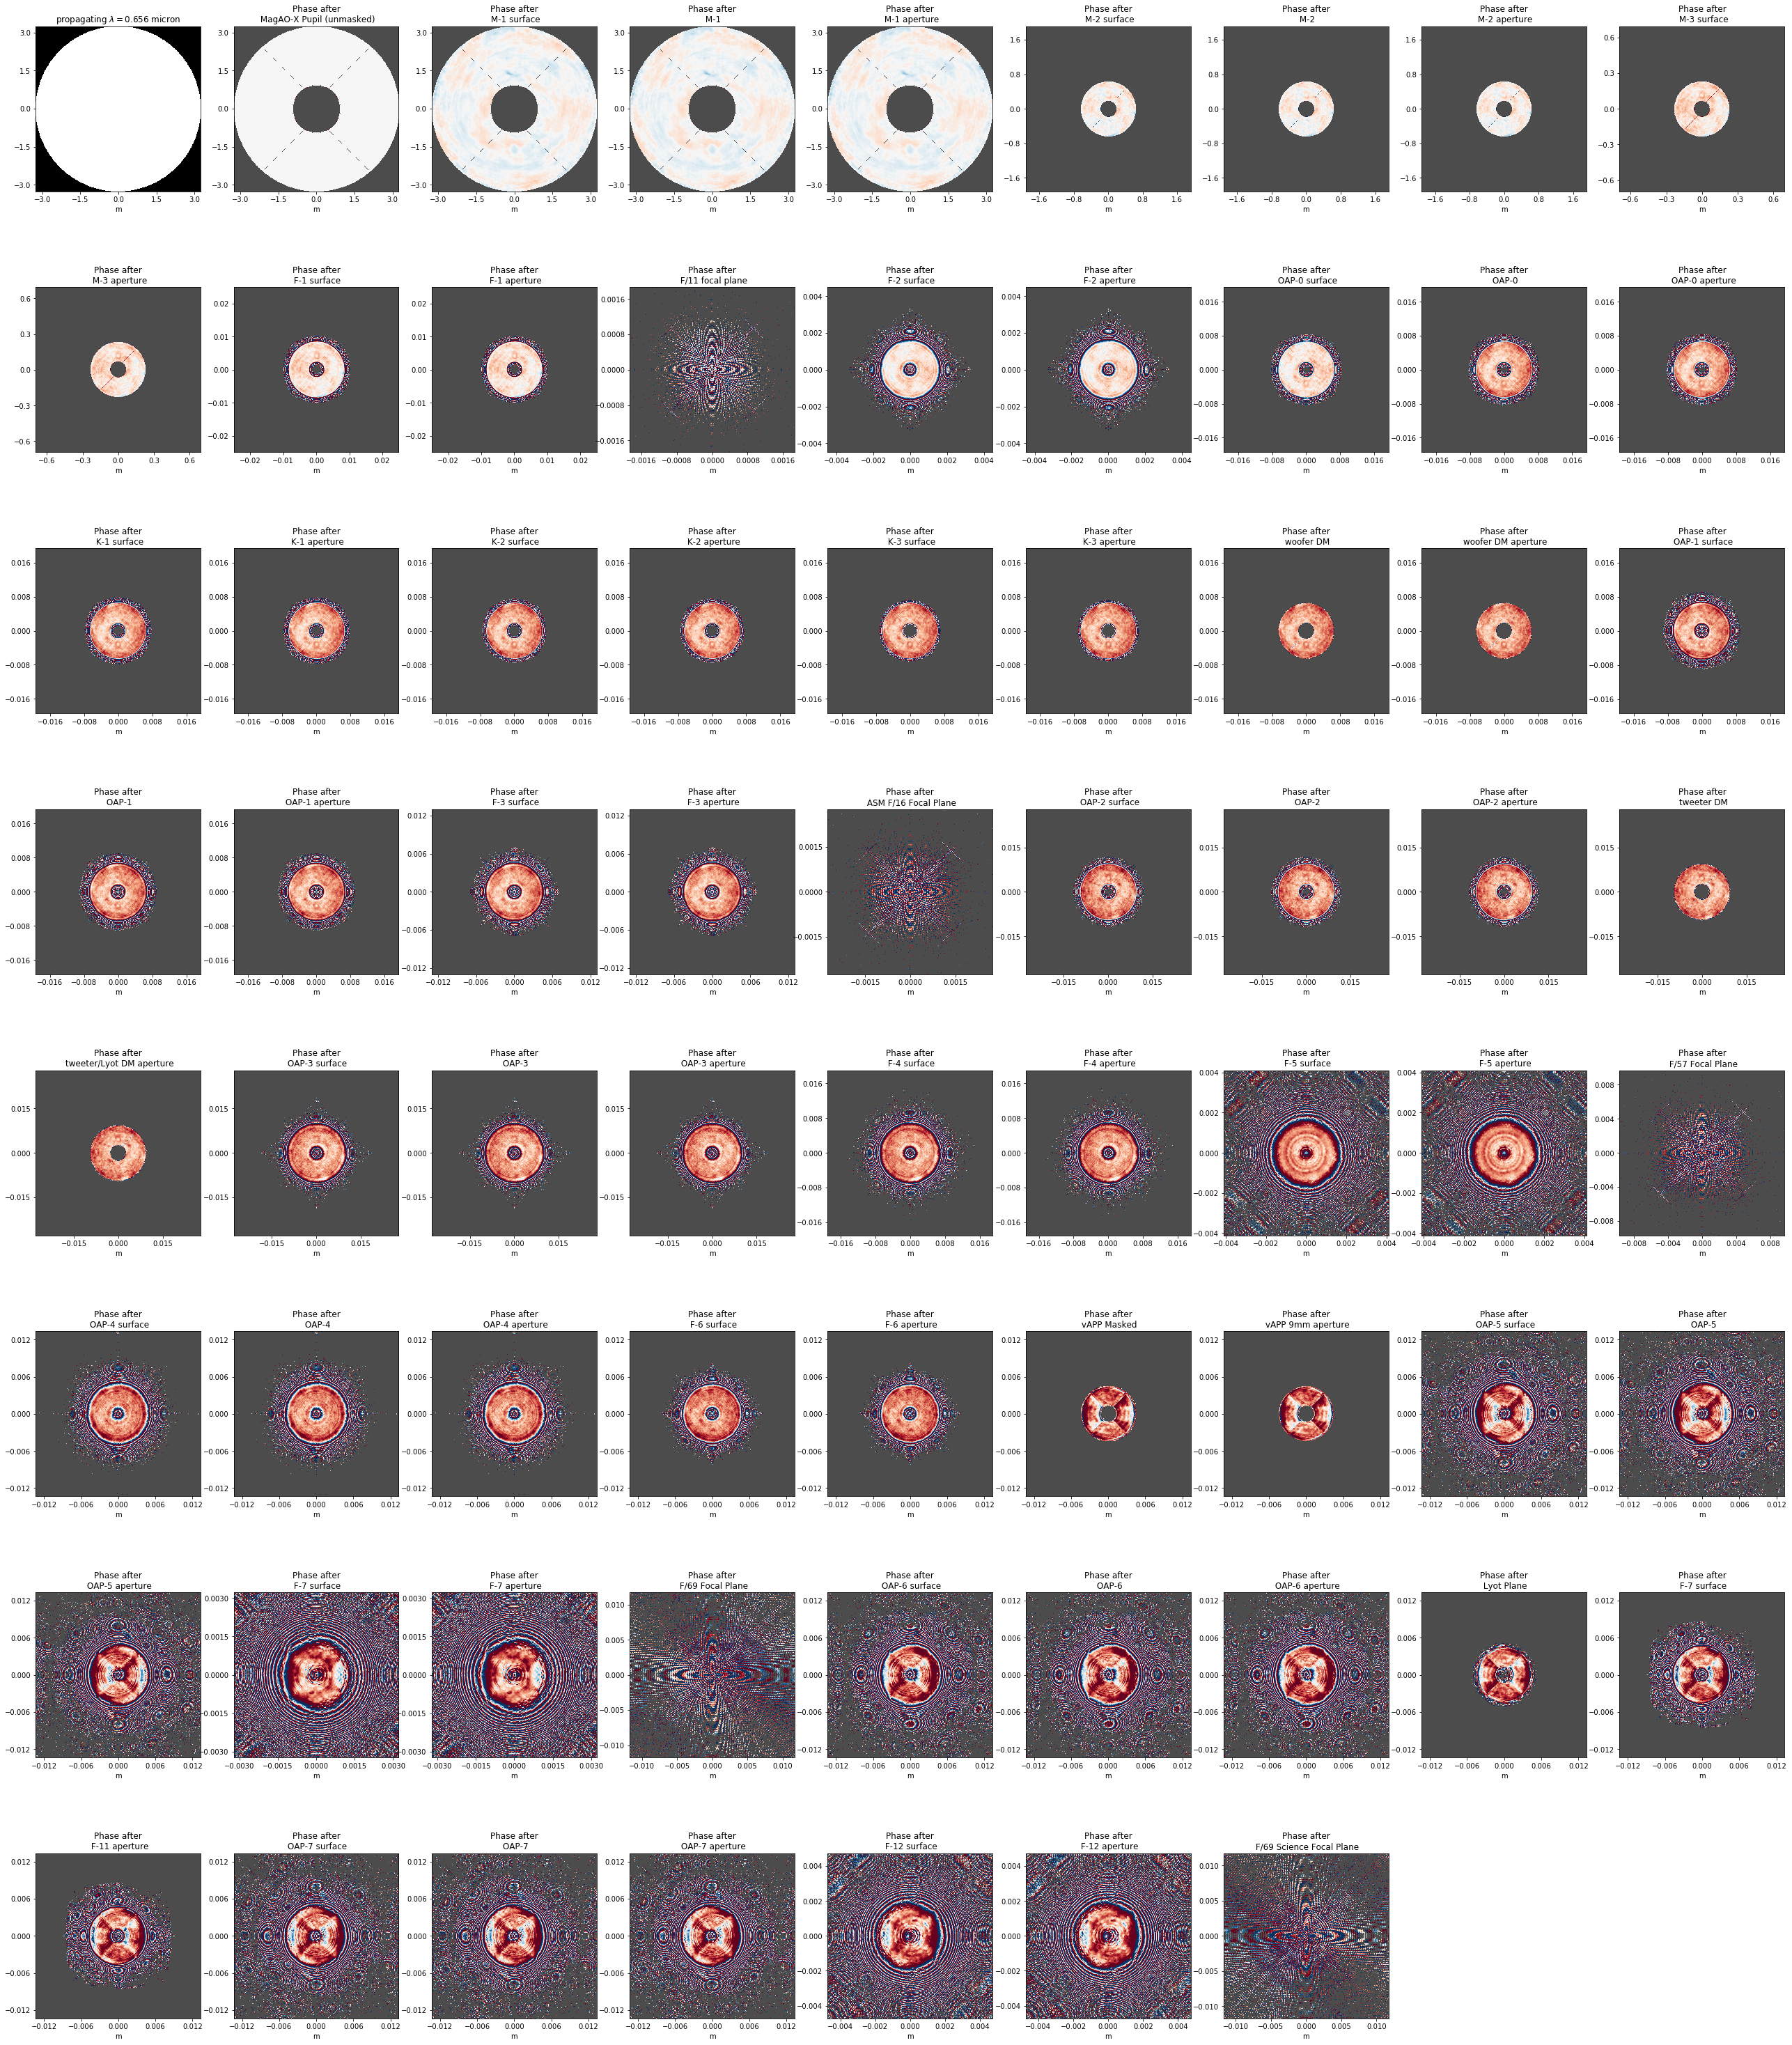

In [8]:
plt.figure(figsize=[45,54])
vapp_psf, vapp_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=True,
                                    return_intermediates=True)

In [9]:
vapp_sci_num=len(vapp_wfs)-1 # last one will be the Lyot plane when all elements after Lyot plane commented out
vapp_wfs[vapp_sci_num].asFITS('intensity').writeto('output/vAPP_refl_scale+1_F69Sci_WithAberration_unmaskedPupil_PSF.fits')
vapp_wfs[vapp_sci_num].asFITS('phase').writeto('output/vAPP_refl_scale+1_F69Sci_WithAberration_unmaskedPupil_Phase.fits')
vapp_complex_wf = vapp_wfs[vapp_sci_num].asFITS('parts')
vapp_wf_amp = fits.PrimaryHDU(data=vapp_complex_wf[0].data[0,:,:],header=vapp_complex_wf[0].header)
vapp_wf_amp.header.remove('plane2') # remove phase header card because only pulled amplitude data
vapp_wf_amp.writeto('output/vAPP_refl_scale+1_F69Sci_WithAberration_unmaskedPupil_Amplitude.fits')

## Side check: Investigating TTM diameter
The vAPP coronagraph will be placed at the TTM location (conjugate location), so this segment checks that the TTM diameter = 9mm, as needed.

In [9]:
pupil = surfFITS(file_loc='data/MagAOX_f11_pupil_256_unmasked.fits', optic_type='trans', opdunit='none', 
                 name='MagAO-X Pupil (unmasked)')

In [10]:
magaox = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*2,
                                       beam_ratio=.34)
# Entrance Aperture
magaox.add_optic(poppy.CircularAperture(radius=M1_radius))

# Add Pupil
magaox.add_optic(pupil)

# Surface: Primary Mirror
magaox.add_optic(M1_surf)
magaox.add_optic(M1)
magaox.add_optic(poppy.CircularAperture(radius=M1_radius,name="M-1 aperture"))

# Surface: Secondary Mirror
magaox.add_optic(M2_surf, distance=d_m1_m2)
magaox.add_optic(M2)
magaox.add_optic(poppy.CircularAperture(radius=M2_radius,name="M-2 aperture"))

# Surface: Tertiary mirror 
magaox.add_optic(M3_surf, distance=d_m2_m3)
magaox.add_optic(poppy.CircularAperture(radius=M3_radius, name="M-3 aperture"))

# Surface: Periscope Mirror 1 (F-1)
magaox.add_optic(peri1_surf, distance=d_m3_wfsdichroic+d_wfsdichroic_peri1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-1 aperture"))

# Surface: F/11 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="F/11 focal plane"), 
                                          distance=d_peri1_f11fp+f11_delta)

# Surface: Periscope Mirror 2 (F-2)
magaox.add_optic(peri2_surf, distance=d_f11fp_peri2)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-2 aperture"))

# Surface: OAP-0 (O-0)
magaox.add_optic(OAP0_surf, distance=d_peri2_oap0)
magaox.add_optic(OAP0)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-0 aperture"))

# Begin K-mirror setup
# Surface: K-1
magaox.add_optic(K1_surf, distance=d_oap0_k1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="K-1 aperture"))

# Surface: K-2
magaox.add_optic(K2_surf, distance=d_k1_k2)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="K-2 aperture"))

# Surface: K-3
magaox.add_optic(K3_surf, distance=d_k2_k3)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="K-3 aperture"))

# Surface: woofer DM mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="woofer DM"), 
                                          distance=d_k3_woofer)
magaox.add_optic(poppy.CircularAperture(radius=dm_radius, name="woofer DM aperture"))

# Surface: OAP-1 (O-1)
magaox.add_optic(OAP1_surf, distance=d_woofer_oap1)
magaox.add_optic(OAP1)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-1 aperture"))

# Surface: Fold Mirror 1 (F-3)
magaox.add_optic(fold1_surf, distance=d_oap1_fold1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-3 aperture"))

# Surface: ASM F/16 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="ASM F/16 Focal Plane"), 
                                          distance=d_fold1_f16fp+f16_delta)

# Surface: OAP-2 (O-2)
magaox.add_optic(OAP2_surf, distance=d_f16fp_oap2)
magaox.add_optic(OAP2)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-2 aperture"))

# Surface: tweeter mirror (Insert Lyot filter here)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="woofer DM"), 
                                          distance=d_oap2_tweeter)
#magaox.add_optic(Lyot_DM, distance=d_oap2_tweeter)
magaox.add_optic(poppy.CircularAperture(radius=dm_radius, name="tweeter/Lyot DM aperture"))

# SKIP: ADC1 at Surface 4&5

# Surface: OAP-3
magaox.add_optic(OAP3_surf, distance=d_tweeter_oap3)
magaox.add_optic(OAP3)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-3 aperture"))

# Surface: Breadboard Fold Mirror 1 (F-4)
magaox.add_optic(F4_surf, distance=d_oap3_breadfm1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-4 aperture"))

# Surface: Breadboard Fold Mirror 2 (F-5)
magaox.add_optic(F5_surf, distance=d_breadfm1_breadfm2)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-5 aperture"))

# Surface: ASM F/57 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="F/57 Focal Plane"), 
                                          distance=d_breadfm2_f57fp+f57_delta)

# Surface: OAP-4 (O-4)
magaox.add_optic(OAP4_surf, distance=d_f57fp_oap4)
magaox.add_optic(OAP4)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-4 aperture"))

# SKIP: ADC1 (Surface 7&8), ADC2 (Surface 9&10)

# Surface: Flat mirror (F-6)
magaox.add_optic(F6_surf, distance=d_oap4_flat6)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-6 aperture"))

# Surface: flat TTM (9mm pupil) / vAPP Coronagraph
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="TTM Pupil Plane"), 
                                          distance=d_flat6_ttm)

C:\Users\Jhen\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Optic(514, 514) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
C:\Users\Jhen\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Optic(514, 514) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
Optic(564, 564) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
Optic(1222, 1222) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the resca

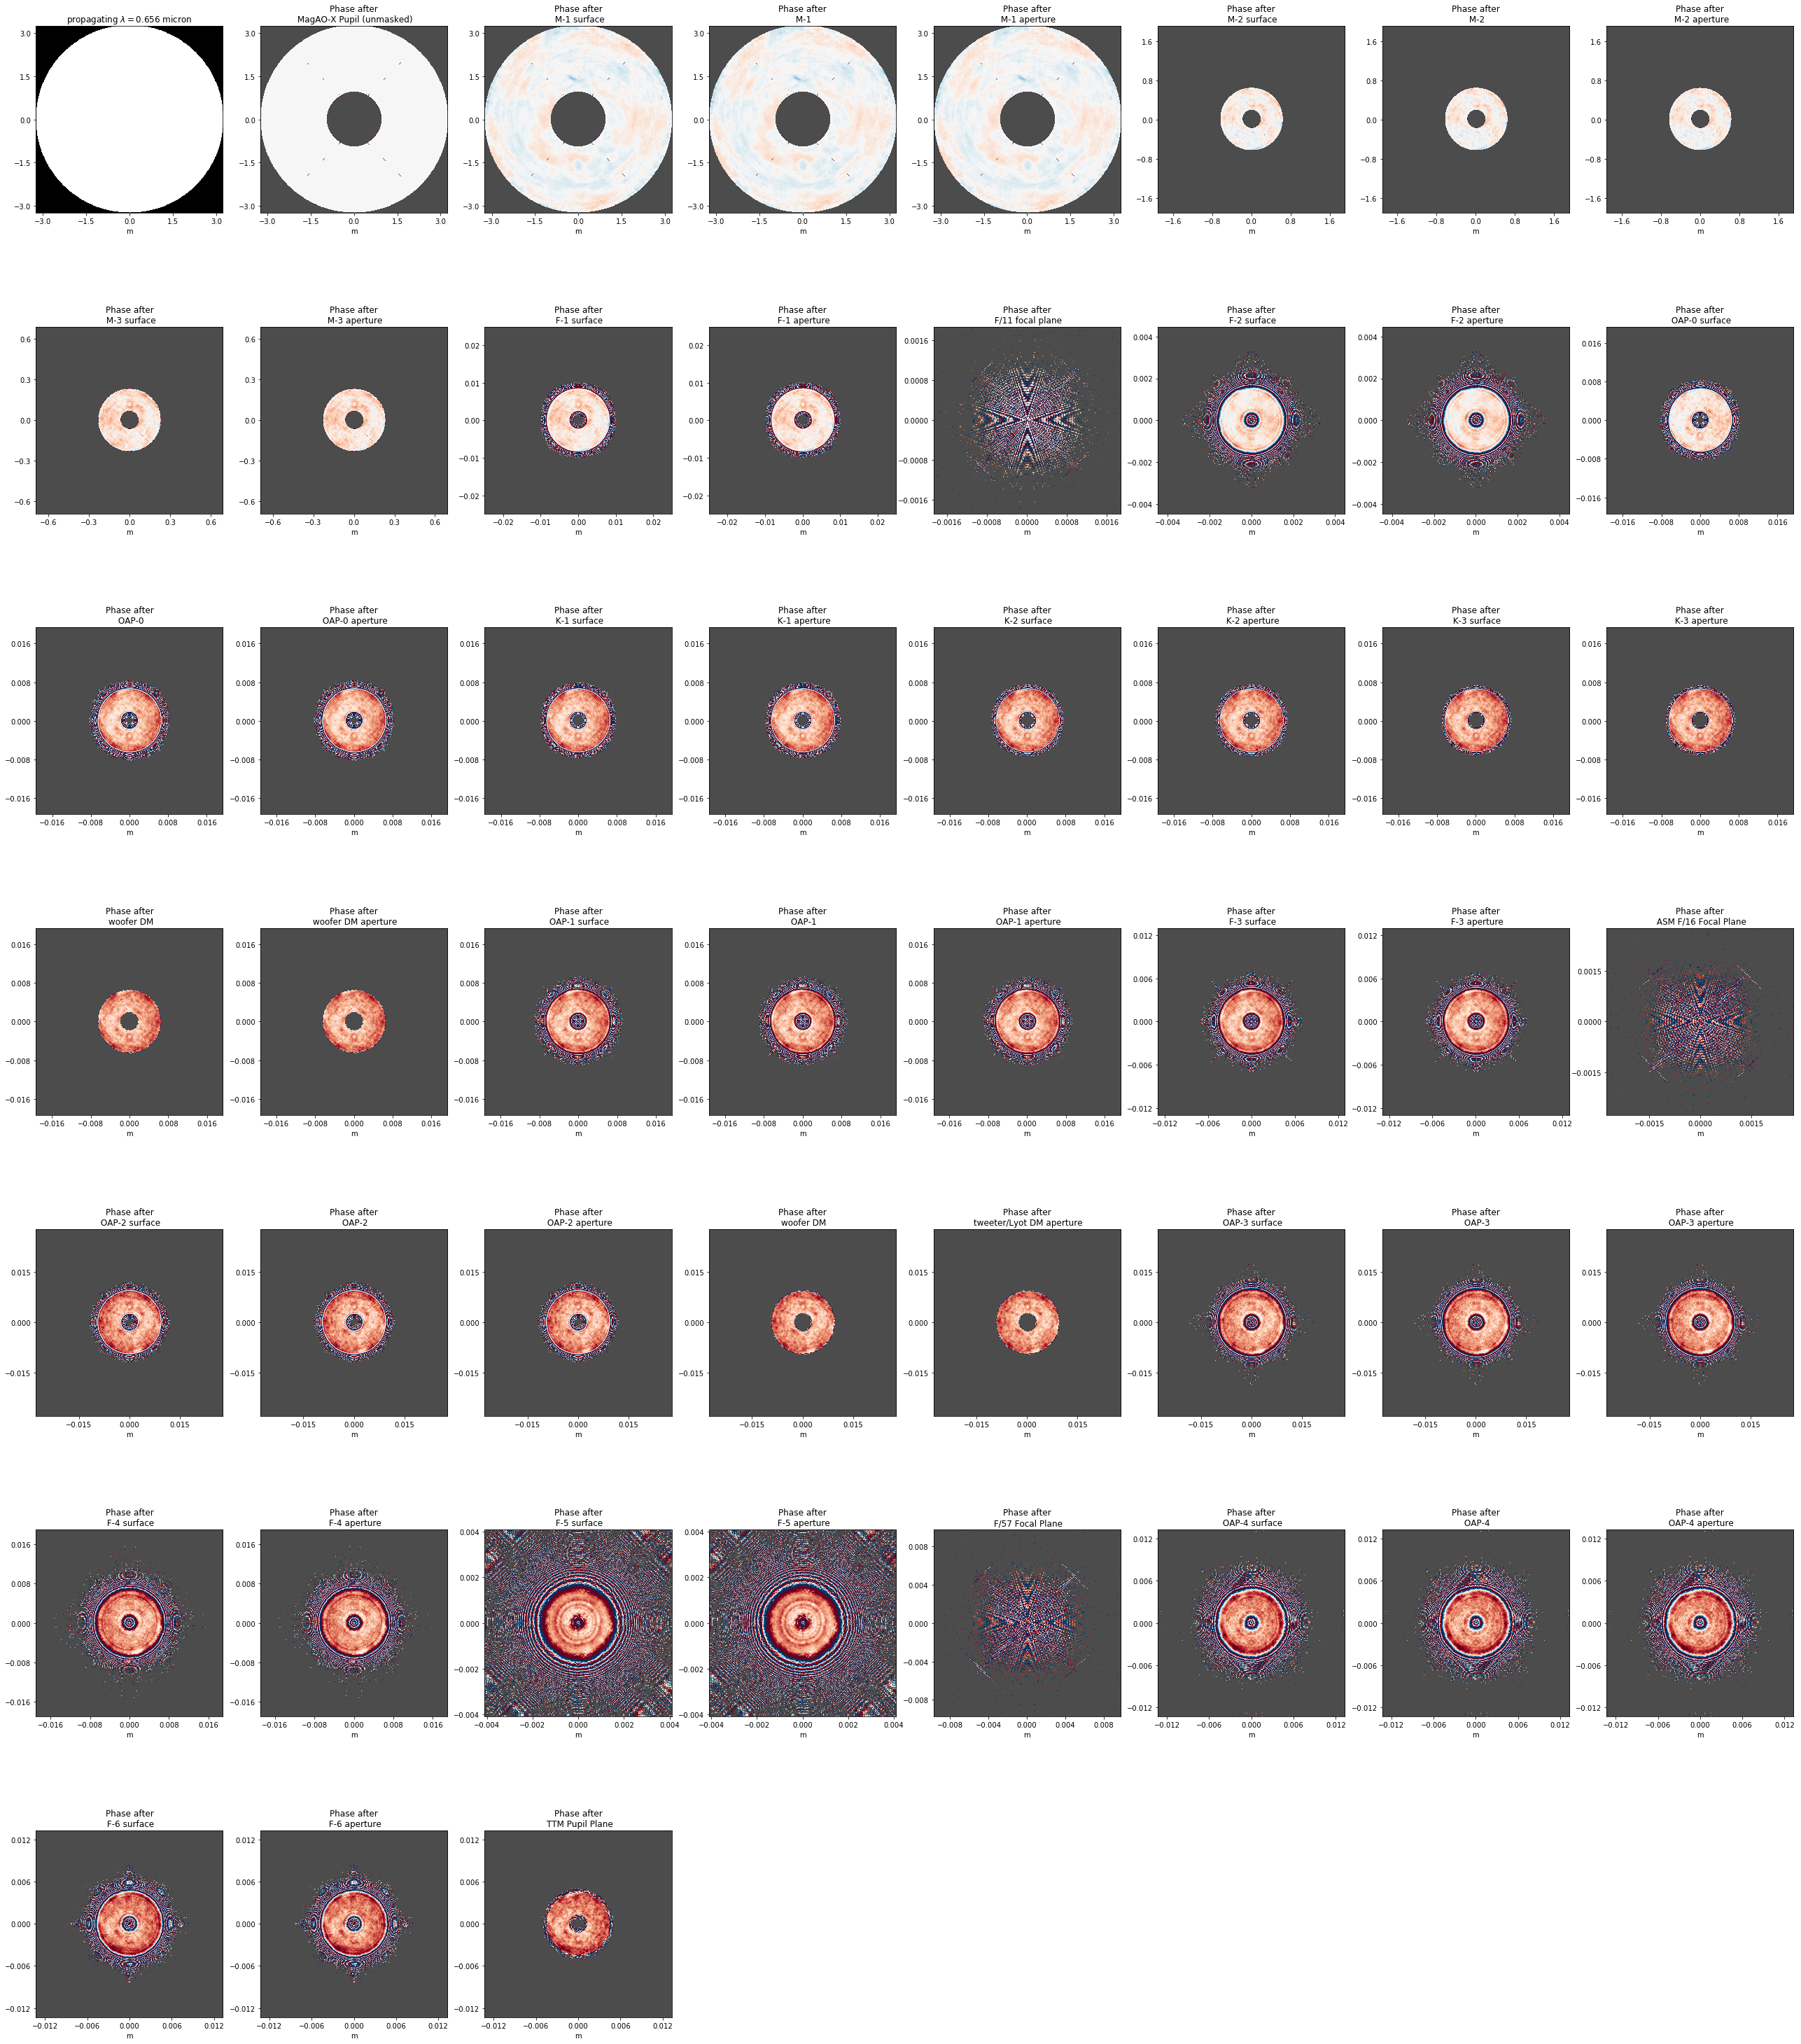

In [11]:
plt.figure(figsize=[45,54])
ttm_psf, ttm_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=True,
                                    return_intermediates=True)

In [12]:
ttm_num=len(ttm_wfs)-1 # last one will be the Lyot plane when all elements after Lyot plane commented out
ttm_phase = ttm_wfs[ttm_num].asFITS('intensity')
ttm_phase.writeto('output/TTM_WithAberration_unmaskedPupil_Intensity.fits')

In [13]:
ttm_pixelscl = ttm_phase[0].header['PIXELSCL']
ttm_pixelscl

1.7305266110657467e-05

Check the size of the pupil in the TTM Intensity map (using 512 pixels for full pupil diameter)

In [14]:
ttm_diam = ttm_pixelscl * 512 * u.m
ttm_diam

<Quantity 0.008860296248656623 m>

The TTM diameter is expected to be 9mm, so this looks good!